In [26]:
from PIL import Image
import requests
import io
import mercantile
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import numpy as np


In [27]:
# Download the following file from https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files or similar
shapefile_path = "../data/SA1_2021_AUST_SHP_GDA2020/SA1_2021_AUST_GDA2020.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.crs)

# getting NSW only SA1 polygons
nsw_gdf = gdf[gdf["STE_CODE21"] == "1"]
nsw_gdf['xmin'] = nsw_gdf['geometry'].bounds['minx']
nsw_gdf['ymin'] = nsw_gdf['geometry'].bounds['miny']
nsw_gdf['xmax'] = nsw_gdf['geometry'].bounds['maxx']
nsw_gdf['ymax'] = nsw_gdf['geometry'].bounds['maxy']

nsw_gdf = nsw_gdf[['SA1_CODE21', 'xmin', 'ymin', 'xmax', 'ymax', 'geometry']]
# nsw_gdf.to_csv("nsw_gdf.csv")

# extract a chatswood SA1 for testing
chatswood_sa1_gdf = nsw_gdf[nsw_gdf['SA1_CODE21'] == '12101168425']

EPSG:7844


/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/xluo3503/opt/anaconda3/envs/aerial-ann/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is tr

In [28]:
class TileImage:
    def __init__(self, url=None, level=None, row=None, column=None):
        """
        Initialize a TileImage object.

        Parameters:
        - url (str, optional): URL or file path of the image.
        - level (int, optional): Level of the image.
        - row (int, optional): Row position of the image.
        - column (int, optional): Column position of the image.
        - image (bytes, optional): Bytes representing the image.
        - x (int, optional): X-coordinate of the image in the final grid.
        - y (int, optional): Y-coordinate of the image in the final grid.
        """
        self.url = url
        self.level = level
        self.row = row
        self.column = column
        self.image = None
        self.x = None
        self.y = None
        self.size = None

    def download_image(self):
        if not self.url:
            return

        params = {
            'blankTile': 'false',
        }
        response = requests.get(self.url, params=params)
        if response.status_code == 200:
            image_bytes = response.content
            self.image = image_bytes
            self.size = Image.open(io.BytesIO(image_bytes)).size
        else:
            print(f"Request failed with status code {response.status_code} for {self.url}")

class SA1Image:
    base_url = "https://maps.six.nsw.gov.au/arcgis/rest/services/sixmaps/LPI_Imagery_Best/MapServer/"

    def __init__(self, sa1_gdf, zoom_level:int):
        """
        Args:
            SA1code (str): code for SA1
            zoom_level (int): zoom level
            bbox (list[float]): SA1 polygon bounding box coordinates [xmin, ymin, xmax, ymax]
        """
        self.SA1code = sa1_gdf.iloc[0]['SA1_CODE21']
        self.SA1_bbox = [sa1_gdf.iloc[0]['xmin'], sa1_gdf.iloc[0]['ymin'], sa1_gdf.iloc[0]['xmax'], sa1_gdf.iloc[0]['ymax']] # this bbox touches the SA1 polgon edges
        self.zoom_level = zoom_level
        self.polygon = sa1_gdf
        self.tile_images = self.download_tile_images()
        self.tiles_bbox = self.calculate_bounding_box()  # this bbox is the bbox for the final image, which should be larger than self.SA1_bbox
        self.row_count = max(self.tile_images, key=lambda x: x.y).y + 1  # calculate the grid coordinates of stitched images
        self.col_count = max(self.tile_images, key=lambda x: x.x).x + 1
        self.image = self.stitch_images()

    def download_tile_images(self):
        tiles = list(mercantile.tiles(*self.SA1_bbox, self.zoom_level))
        tile_images = []

        for tile in tiles:
            print(f"Zoom Level: {self.zoom_level}, Column (X): {tile.x}, Row (Y): {tile.y}")
            url = f'{SA1Image.base_url}/tile/{self.zoom_level}/{tile.y}/{tile.x}'
            tile_image = TileImage(url=url, level=self.zoom_level, row=tile.y, column=tile.x)
            tile_image.download_image()
            tile_images.append(tile_image)

        #  calculate where each tile should be placed in the final grid
        smallest_row = min(tile_images, key=lambda x: x.row).row
        smallest_column = min(tile_images, key=lambda x: x.column).column

        for tile_image in tile_images:
            tile_image.x = tile_image.column - smallest_column
            tile_image.y = tile_image.row - smallest_row
            
        return tile_images

    def calculate_bounding_box(self):  # extent coordinates for matplotlib
        if not self.tile_images:
            return None

        top_left_tile = next((tile for tile in self.tile_images if tile.x == 0 and tile.y == 0), None)
        bottom_right_tile = max(self.tile_images, key=lambda tile: (tile.x, tile.y), default=None)

        ul_coordinates = mercantile.ul(top_left_tile.column, top_left_tile.row, top_left_tile.level)
        top_left_lat, top_left_lng = ul_coordinates.lat, ul_coordinates.lng

        bottom_right_tile = mercantile.bounds(bottom_right_tile.column, bottom_right_tile.row, top_left_tile.level)
        bottom_right_lng, bottom_right_lat = bottom_right_tile.east, bottom_right_tile.south

        return [top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat]

    def stitch_images(self) -> Image.Image:
        if not self.tile_images:
            return None

        # Find dimensions of the final image based on the maximum x and y coordinates in the grid
        max_x = max(tile.x for tile in self.tile_images)
        max_y = max(tile.y for tile in self.tile_images)

        tile_width, tile_height = self.tile_images[0].size

        # Calculate the actual dimensions of the final image based on the grid.
        final_width = (max_x + 1) * tile_width
        final_height = (max_y + 1) * tile_height

        # Create an empty image with the calculated dimensions.
        final_image = Image.new('RGB', (final_width, final_height))

        # Paste each tile image onto the final image based on its grid coordinates.
        for tile in self.tile_images:
            if tile.image:
                tile_image = Image.open(io.BytesIO(tile.image))
                paste_x = tile.x * tile_width
                paste_y = tile.y * tile_height
                final_image.paste(tile_image, (paste_x, paste_y))

        return final_image

    def plot(self):
        fig, ax = plt.subplots()

        ax.imshow(self.image, extent=self.tiles_bbox)

        self.polygon.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        plt.show()
        
    def save_as_geotiff(self):
        width, height = self.image.size

        # Replace lon1, lon2, lat1, lat2 with the left side, right side, bottom side, top side bbox coordinates of the area
        # top_left_lng, bottom_right_lng, bottom_right_lat, top_left_lat
        lon1, lon2, lat1, lat2 = self.tiles_bbox

        # Calculate the pixel width and pixel height
        pixel_width = (lon2 - lon1) / width
        pixel_height = (lat1 - lat2) / height

        print("pixel_width", pixel_width, "pixel_height", pixel_height)

        crs = rasterio.crs.CRS.from_epsg(7844)
        transform = from_origin(lon1, lat2, pixel_width, -pixel_height)  

        image_array = np.array(self.image)

        height, width, _ = image_array.shape

        # Create a GeoTIFF file and write the image array to it
        with rasterio.open(f'{self.SA1code}.tif', 'w', driver='GTiff', width=width, height=height, crs=crs, transform=transform, dtype=image_array.dtype, count=image_array.shape[2]) as dst:
            for i in range(image_array.shape[2]):
                dst.write(image_array[:, :, i], i + 1)

In [29]:
chatswood_sa1_image = SA1Image(chatswood_sa1_gdf, 18)

Zoom Level: 18, Column (X): 241161, Row (Y): 157245
Zoom Level: 18, Column (X): 241161, Row (Y): 157246
Zoom Level: 18, Column (X): 241161, Row (Y): 157247
Zoom Level: 18, Column (X): 241162, Row (Y): 157245
Zoom Level: 18, Column (X): 241162, Row (Y): 157246
Zoom Level: 18, Column (X): 241162, Row (Y): 157247
Zoom Level: 18, Column (X): 241163, Row (Y): 157245
Zoom Level: 18, Column (X): 241163, Row (Y): 157246
Zoom Level: 18, Column (X): 241163, Row (Y): 157247


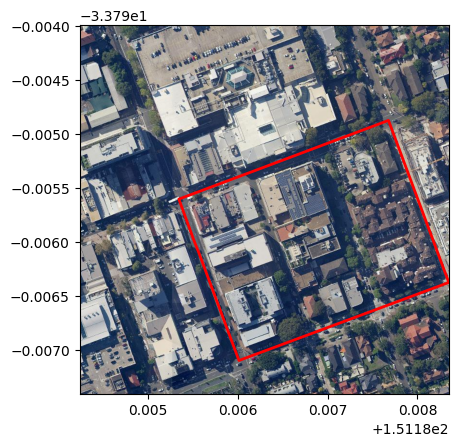

In [30]:
chatswood_sa1_image.plot()

In [31]:
chatswood_sa1_image.save_as_geotiff()

pixel_width 5.364418029785156e-06 pixel_height -4.457972178610141e-06
